In [1]:
import os
import numpy as np
import pandas as pd
import random


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix


from river import compose, preprocessing, metrics, datasets
from river import evaluate
from deep_river.classification import Classifier

import deep_river
from river import compat
from river import stream
import torch.optim as optim

from collections import Counter



from deep_river.anomaly import RollingAutoencoder
from deep_river import classification

from torch import nn, manual_seed
import torch.nn.functional as F
import torch
from tqdm import tqdm


In [ ]:
# Define defaults

# Set seed for NumPy
np.random.seed(42)

FILENAME = "../../datasets/BCCC-CIC-IDS-2017/subsets/training_v1.csv"
FILENAME_TEST = "../../datasets/BCCC-CIC-IDS-2017/subsets/test_v1.csv"

In [3]:
# Load csv file
df = pd.read_csv(FILENAME, low_memory=False)
df_test = pd.read_csv(FILENAME_TEST, low_memory=False)

In [4]:
df.shape

(562799, 109)

In [5]:
df_test.shape

(562800, 109)

In [6]:
X_train = df.drop("label", axis=1)
y_train = df["label"]


X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

In [7]:
df['label'].value_counts()

label
0    364830
3    141652
1     47301
2      3878
4      2798
5      2340
Name: count, dtype: int64

In [8]:
attack_types = df['label'].unique()
attack_types

array([0, 3, 1, 5, 4, 2])

In [9]:
# Select attacks to exclude from training (simulate unseen attacks)
seen_attacks = attack_types[:int(len(attack_types) * 0.8)]
unseen_attacks = attack_types[int(len(attack_types) * 0.8):]

In [10]:
seen_attacks

array([0, 3, 1, 5])

In [11]:
unseen_attacks

array([4, 2])

In [12]:
X_train_seen = X_train[y_train.isin(seen_attacks)]
y_train_seen = y_train[y_train.isin(seen_attacks)]

In [13]:
# Further split test set to include unseen attacks
X_test_seen = X_test[y_test.isin(seen_attacks)]
y_test_seen = y_test[y_test.isin(seen_attacks)]
X_test_unseen = X_test[y_test.isin(unseen_attacks)]
y_test_unseen = y_test[y_test.isin(unseen_attacks)]

In [14]:
# convert to a bianry classification
y_train_seen = (y_train_seen != 0).astype(int)
y_test_unseen = (y_test_unseen != 0).astype(int)
y_test_seen = (y_test_seen != 0).astype(int)

In [15]:
y_train_seen.value_counts()

label
0    364830
1    191293
Name: count, dtype: int64

In [16]:
y_test_unseen.value_counts()


label
1    6602
Name: count, dtype: int64

In [17]:
y_test_seen.value_counts()

label
0    365427
1    190771
Name: count, dtype: int64

In [18]:
X_test_unseen.shape

(6602, 108)

In [19]:
y_test_unseen.shape

(6602,)

In [20]:
class MyModule(nn.Module):
    def __init__(self, n_features, input_size=108, hidden_size1=64, hidden_size2=32,
                 dropout_rate=0.2, num_layers=1):
        super(MyModule, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 256, num_layers=num_layers, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(256, 128, num_layers=num_layers, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.lstm3 = nn.LSTM(128, 64, num_layers=num_layers, batch_first=True)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(64, 32)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(32, 1)  # Single output for binary classification

    def forward(self, X):
        out, _ = self.lstm1(X)
        out = self.dropout1(out)

        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        
        out, _ = self.lstm3(out)
        out = self.dropout3(out)
        
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.dropout4(out)

        if out.dim() == 3:
            out = out[:, -1, :]

        return self.fc2(out)  


In [21]:
metric = metrics.ROCAUC(n_thresholds=50)

model_pipeline = compose.Pipeline(
    classification.Classifier(module=MyModule, loss_fn='binary_cross_entropy_with_logits', optimizer_fn='adam', output_is_logit=True, lr=0.001, is_feature_incremental=False,is_class_incremental=False, seed=42)
    )

In [22]:
# Merge the dataset
from sklearn.utils import shuffle

df_train = pd.concat([X_train_seen, y_train_seen], axis=1)
df_test = pd.concat([X_test_unseen, y_test_unseen], axis=1)


df_train['source'] = 'train'
df_test['source'] = 'test'

df_merged = pd.concat([df_train, df_test])  # Merging along columns

# df_shuffled = shuffle(df_merged, random_state=42).reset_index(drop=True)

test_indices_in_combined = df_merged[df_merged['source'] == 'test'].index.tolist()

df_final = df_merged.drop(columns='source')



In [23]:
test_indices_in_combined[0:10]

[35, 215, 401, 428, 672, 868, 915, 964, 1125, 1150]

In [24]:
len(test_indices_in_combined)

6602

In [25]:
df_final.shape

(562725, 109)

In [26]:
pd.set_option('display.max_columns', None)
print(df_final.columns.tolist())


['fwd_rst_flag_counts', 'rst_flag_counts', 'bwd_avg_segment_size', 'bwd_payload_bytes_variance', 'payload_bytes_std', 'bwd_payload_bytes_std', 'fwd_payload_bytes_std', 'payload_bytes_variance', 'payload_bytes_mean', 'fwd_payload_bytes_mean', 'bwd_payload_bytes_mean', 'avg_segment_size', 'payload_bytes_max', 'fwd_payload_bytes_max', 'bwd_payload_bytes_max', 'packet_IAT_min', 'packets_IAT_mean', 'packet_IAT_max', 'packet_IAT_total', 'fwd_packets_IAT_min', 'fwd_packets_IAT_mean', 'fwd_packets_IAT_total', 'fwd_packets_IAT_max', 'bwd_std_header_bytes', 'active_std', 'idle_min', 'idle_mean', 'idle_max', 'bwd_rst_flag_counts', 'fwd_std_header_bytes', 'std_header_bytes', 'fwd_syn_flag_counts', 'bwd_init_win_bytes', 'bwd_fin_flag_counts', 'fwd_packets_IAT_std', 'fwd_init_win_bytes', 'bwd_packets_IAT_min', 'bwd_packets_IAT_mean', 'bwd_packets_IAT_max', 'bwd_packets_IAT_total', 'bwd_max_header_bytes', 'packet_IAT_std', 'syn_flag_counts', 'bwd_bytes_rate', 'min_header_bytes', 'fwd_bulk_duration', 

In [27]:
X = df_final.drop("label", axis=1)
y = df_final["label"]

In [28]:
y.value_counts()

label
0    364830
1    197895
Name: count, dtype: int64

In [29]:
y.shape

(562725,)

In [30]:
# Inference + learning


predictions = []
ground_truth = []

rocauc_x_vals = []
rocauc_y_vals = []

index = 0

for xi, yi in tqdm(stream.iter_pandas(X, y)):
    y_pred = model_pipeline.predict_one(xi)
    
    if index not in (test_indices_in_combined):        
        model_pipeline.learn_one(xi, yi) # make the model learn (seen)
    
    if index in (test_indices_in_combined):
    
        if isinstance(y_pred, int):
            metric.update(yi, y_pred)
            predictions.append(y_pred)
            ground_truth.append(yi)
            rocauc_x_vals.append(index)
            rocauc_y_vals.append(metric.get())  
    
    
    index += 1

print(f"ROCAUC: {metric.get():.4f}")

0it [00:00, ?it/s]/Users/alberto.llamas/anaconda3/envs/rag11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
562725it [26:23, 355.43it/s]

ROCAUC: 0.6974


In [31]:
print(classification_report(ground_truth, predictions, zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     0.7612    0.8996    0.8246      4234
           1     0.7339    0.4951    0.5913      2367

    accuracy                         0.7546      6601
   macro avg     0.7475    0.6974    0.7080      6601
weighted avg     0.7514    0.7546    0.7410      6601



In [32]:
print(model_pipeline._get_params)

<bound method Pipeline._get_params of Pipeline (
  Classifier (
    module=MyModule(
    (lstm1): LSTM(108, 256, batch_first=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (lstm2): LSTM(256, 128, batch_first=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (lstm3): LSTM(128, 64, batch_first=True)
    (dropout3): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=32, bias=True)
    (dropout4): Dropout(p=0.2, inplace=False)
    (fc2): Linear(in_features=32, out_features=1, bias=True)
  )
    loss_fn="binary_cross_entropy_with_logits"
    optimizer_fn="adam"
    lr=0.001
    output_is_logit=True
    is_class_incremental=False
    is_feature_incremental=False
    device="cpu"
    seed=42
  )
)>


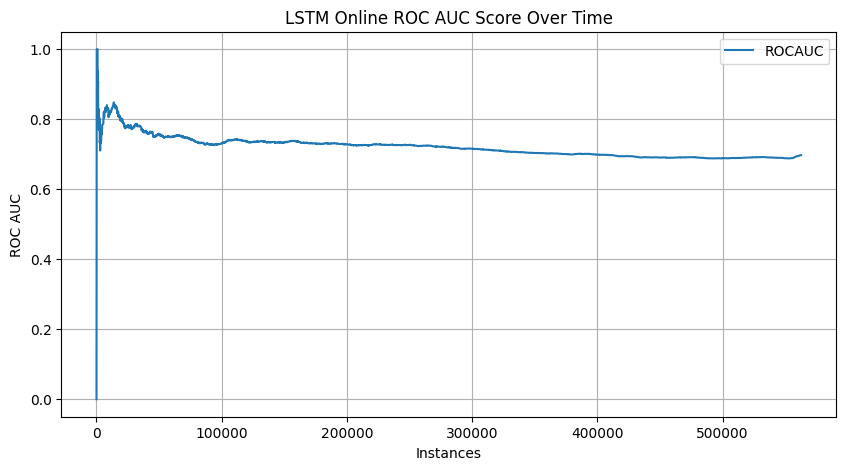

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(rocauc_x_vals, rocauc_y_vals, label='ROCAUC')
plt.xlabel('Instances')
plt.ylabel('ROC AUC')
plt.title('LSTM Online ROC AUC Score Over Time')
plt.grid(True)
plt.legend()
plt.show()


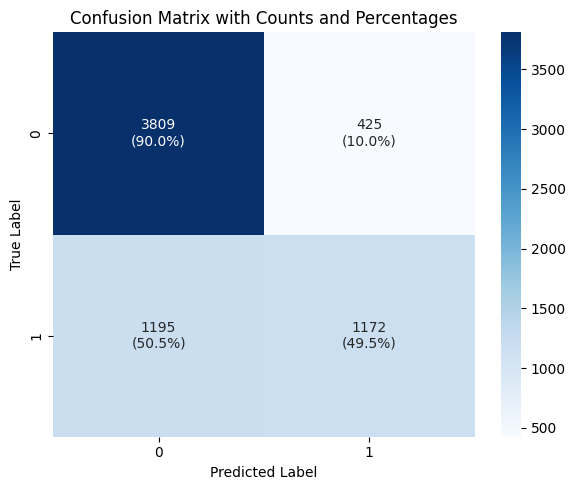

In [34]:
# Create annotations combining count and percentage
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [0, 1]
cm = confusion_matrix(ground_truth, predictions, labels=labels)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
cm_percent = np.nan_to_num(cm_percent)  # Handle division by zero if any


# Create annotations combining count and percentage
annotations = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annotations[i, j] = f'{count}\n({percent:.1f}%)'

# Plot heatmap with both count and percentage
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix with Counts and Percentages')

plt.tight_layout()
plt.show()